# Notebook 5 - Double ML (teacher notebook)

Let's look at the "Twins" data, which was used in the academic paper: Almond D et al. "The costs of low birth weight." The Quarterly Journal of Economics 120.3 (2005): 1031-1083.


In [1]:
import doubleml as dml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
# Windows users: replace the following line with `df = pd.read_csv(r"..\..\data\twins.csv.gz")`
df = pd.read_csv("../../data/twins.csv.gz", compression='gzip')

## This dataset has lots of columns in it. If you'd like to learn more about this data [you can visit this repo](https://github.com/AMLab-Amsterdam/CEVAE/blob/master/datasets/TWINS/ReadmeTwins).

The outcome of interest:
* `dbirwt_0` represents birthweight (in grams)

The "treatment" of interest:
* `tobacco` represents whether there was smoking present in the family while the mother was pregnant

All the covariates:
* 'adequacy': 'adequacy of care',
* 'alcohol': 'risk factor, alcohol use',
* 'anemia': 'risk factor, Anemia',
* 'birattnd': 'medical person attending birth',
* 'birmon': 'birth month Jan-Dec',
* 'bord_0': 'birth order of lighter twin',
* 'brstate': 'state of residence NCHS',
* 'brstate_reg': 'US census region of brstate',
* 'cardiac': 'risk factor, Cardiac',
* 'chyper': 'risk factor, Hypertension, chronic',
* 'cigar6': 'num of cigarettes /day, quantiled',
* 'crace': 'race of child',
* 'csex': 'sex of child',
* 'data_year': 'year: 1989, 1990 or 1991',
* 'dfageq': 'octile age of father',
* 'diabetes': 'risk factor, Diabetes',
* 'dlivord_min': 'number of live births before twins',
* 'dmar': 'married',
* 'drink5': 'num of drinks /week, quantiled',
* 'dtotord_min': 'total number of births before twins',
* 'eclamp': 'risk factor, Eclampsia',
* 'feduc6': 'education category',
* 'frace': 'dad race',
* 'gestat10': 'gestation 10 categories',
* 'hemo': 'risk factor Hemoglobinopathy',
* 'herpes': 'risk factor, Herpes',
* 'hydra': 'risk factor Hvdramnios/Oliqohvdramnios',
* 'incervix': 'risk factor, Incompetent cervix',
* 'infant_id_0': 'infant id of lighter twin in original df',
* 'lung': 'risk factor, Lung',
* 'mager8': 'mom age',
* 'meduc6': 'mom education',
* 'mplbir': 'mom place of birth',
* 'mplbir_reg': US census region of mplbir',
* 'mpre5': 'trimester prenatal care begun, 4 is none',
* 'mrace': 'mom race',
* 'nprevistq': 'quintile number of prenatal visits',
* 'orfath': 'dad hispanic',
* 'ormoth': 'mom hispanic',
* 'othermr': 'risk factor, Other Medical Risk Factors',
* 'phyper': 'risk factor, Hypertension, preqnancy-associated',
* 'pldel': 'place of delivery',
* 'pre4000': 'risk factor, Previous infant 4000+ grams',
* 'preterm': 'risk factor, Previos pre-term or small',
* 'renal': 'risk factor, Renal disease',
* 'rh': 'risk factor, RH sensitization',
* 'stoccfipb': 'state of occurence FIPB',
* 'stoccfipb_reg': 'US census region of stoccfipb',
* 'uterine': 'risk factor, Uterine bleeding'



## The `DoubleML` package requires an interesting workflow. First, you need to instantiate a "data model" in which you specify the outcome, the treatment, and the covariates

In [3]:
# We pick out a set of potential confounders to control for
features_base = [
    'mager8', 'csex', 'anemia', 
    'cardiac', 'lung', 'diabetes', 'herpes', 'eclamp',
    'preterm', 'renal', 'rh', 'alcohol', 'dfageq',
]

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = dml.DoubleMLData(
    df,
    y_col='dbirwt_0',
    d_cols='tobacco',
    x_cols=features_base
)

print(data_dml_base)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: dbirwt_0
Treatment variable(s): ['tobacco']
Covariates: ['mager8', 'csex', 'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'eclamp', 'preterm', 'renal', 'rh', 'alcohol', 'dfageq']
Instrument variable(s): None
No. Observations: 32120

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32120 entries, 0 to 32119
Columns: 51 entries, dbirwt_0 to mplbir_reg
dtypes: float64(39), int64(12)
memory usage: 12.5 MB



## Now that we have instantiated our "data model", we can setup our "learners". These learners are typically just scikit-learn models. 

## Remember, in Double ML we construct a model to predict the outcome given all covariates and the treatment, and we also construct a model to predict treatment status from all of the covariates (hence the "double" in Double ML). The outcome is continuous and the treatment in this case is binary, so we'll need one regression learner and one classification learner

In [4]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5)
rf_class = RandomForestClassifier(n_estimators=500, max_depth=5)

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_g = rf,
                                 ml_m = rf_class,
                                 n_folds = 3)

dml_plr_forest.fit(store_predictions=True)

C:\Users\ronik\AppData\Local\Temp\ipykernel_7812\419628752.py:5: DeprecationWarning: The required positional argument ml_g was renamed to ml_l. Please adapt the argument name accordingly. ml_g is redirected to ml_l. The redirection will be removed in a future version.
  dml_plr_forest = dml.DoubleMLPLR(data_dml_base,


In [5]:
dml_plr_forest.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
tobacco,-178.390628,9.412588,-18.952347,4.223244e-80,-196.838961,-159.942294


## And there you have it. The Double ML model predicts that family tobacco use while the mother was pregnant results in a 178 gram reduction in birthweight in this population (adjusting for confounding). We can see from the output that this is a statistically significant result, as the 95% confidence interval doesn't overlap with 0. 

<div class="alert alert-success">
    <h3>EXERCISE: Try estimating this treatment effect using a different set of learners. How does the results compare?</h3>
</div>

In [6]:
lin = LinearRegression()
lin_class = LogisticRegression()

np.random.seed(123)
dml_plr_linear = dml.DoubleMLPLR(data_dml_base,
                                 ml_g = lin,
                                 ml_m = lin_class,
                                 n_folds = 3)

dml_plr_linear.fit(store_predictions=True)

C:\Users\ronik\AppData\Local\Temp\ipykernel_7812\3003762421.py:5: DeprecationWarning: The required positional argument ml_g was renamed to ml_l. Please adapt the argument name accordingly. ml_g is redirected to ml_l. The redirection will be removed in a future version.
  dml_plr_linear = dml.DoubleMLPLR(data_dml_base,


In [7]:
dml_plr_linear.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
tobacco,-180.751095,9.440232,-19.14689,1.027419e-81,-199.253611,-162.248579


In [8]:
DTR = DecisionTreeRegressor()
DTC = DecisionTreeClassifier()

np.random.seed(123)
dml_plr_DT = dml.DoubleMLPLR(data_dml_base,
                                 ml_g = DTR,
                                 ml_m = DTC,
                                 n_folds = 3)

dml_plr_DT.fit(store_predictions=True)


C:\Users\ronik\AppData\Local\Temp\ipykernel_7812\3221571831.py:5: DeprecationWarning: The required positional argument ml_g was renamed to ml_l. Please adapt the argument name accordingly. ml_g is redirected to ml_l. The redirection will be removed in a future version.
  dml_plr_DT = dml.DoubleMLPLR(data_dml_base,


In [9]:
dml_plr_DT.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
tobacco,-176.450517,9.563725,-18.449979,5.216570e-76,-195.195073,-157.705961


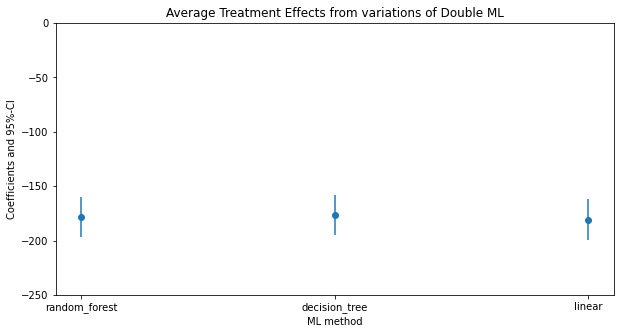

In [10]:
plr_summary = pd.concat((dml_plr_forest.summary, dml_plr_DT.summary, dml_plr_linear.summary))
plr_summary.index = ['random_forest', 'decision_tree', 'linear']
plr_summary[['coef', '2.5 %', '97.5 %']]

errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([-250, 0])

plt.title('Average Treatment Effects from variations of Double ML')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

Looks like these three different sets of learners give us about the same result in terms of ATE